
# EU Energi Energi PDataset

Dataset pertama berisi data dari berbagai negara UE, dari 1986 hingga 2015, tentang Potensi Energi Angin per Jam.

Dataset kedua berisi informasi tentang pembangkit tenaga angin itu sendiri, sepanjang periode waktu yang sama.

Masih banyak yang harus diperbaiki, yaitu dalam domain plotting. Setiap tanggapan konstruktif sangat disambut.

In [43]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.dates as pltdt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")


## Dimulai dengan Dataframe, JAM vs NEGARA

In [44]:
coun = pd.read_csv("EMHIRESPV_TSh_CF_Country_19862015.csv")
coun.head(3)

,AT,BE,BG,CH,CY,CZ,DE,DK,EE,ES,...,LV,NL,NO,PL,PT,RO,SI,SK,SE,UK
0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
coun.shape

(262968, 29)

In [22]:
t = pd.date_range('1/1/1986', periods = 262968, freq = 'H')

Mari kita lihat profil energi angin untuk semua negara pada hari terakhir dan pada bulan terakhir tahun lalu.

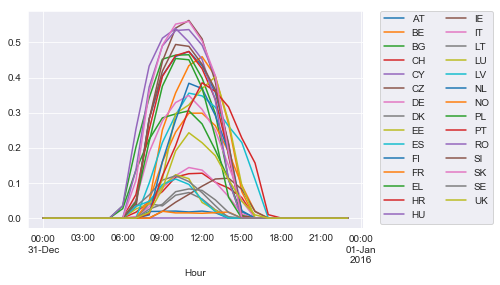

In [23]:
coun["Hour"] = t
coun.set_index("Hour", inplace = True, )
coun['2015-12-31'].plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol = 2,  borderaxespad=0.)

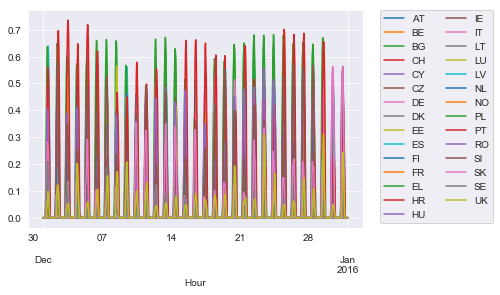

In [24]:
coun['2015-12'].plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol = 2,  borderaxespad=0.)

## per Hari

Garis-garis berada di semua tempat,tetapi kita dapat dengan jelas melihat pola.

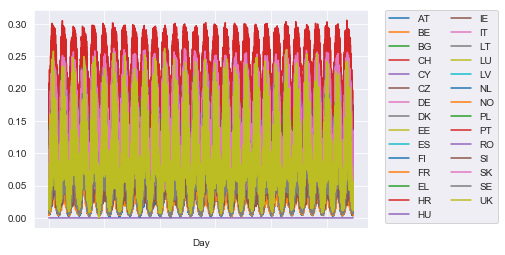

In [25]:
coun['Day']=coun.index.map(lambda x: x.strftime('%Y-%m-%d'))
c_group_day = coun.groupby('Day').mean()
c_group_day.plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol = 2,  borderaxespad=0.)

Siprus selalu memiliki nilai nol untuk Potensi Energi Angin dan menjadi sangat jelas dalam gambar tersebut

## per Bulan

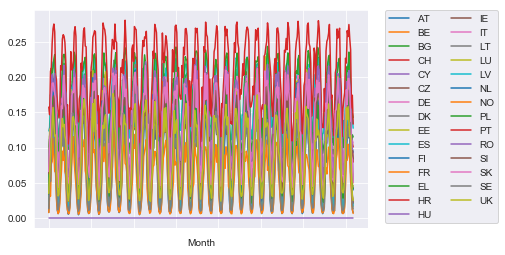

In [26]:
coun['Month']=coun.index.map(lambda x: x.strftime('%Y-%m'))
coun['Month_only']=coun.index.map(lambda x: x.strftime('%m'))
c_group_month = coun.groupby('Month').mean()
c_group_month.plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol = 2,  borderaxespad=0.)

## per Tahun

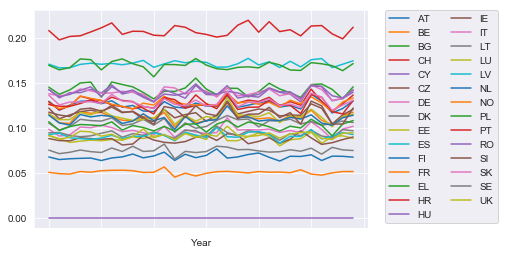

In [27]:
coun['Year']=coun.index.map(lambda x: x.strftime('%Y'))
c_group_year = coun.groupby('Year').mean()
c_group_year.plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol = 2,  borderaxespad=0.)

# Memperbesar tampilan di Portugal

Mari kita mulai dengan melihat apa yang dilakukan Portugal di sektor energi angin dalam periode 30 tahun ini.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  


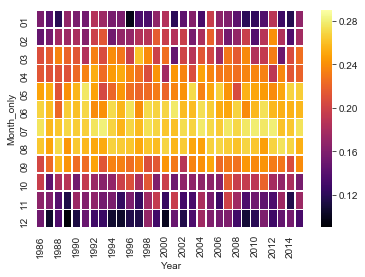

In [28]:
pt_heatmap = coun.pivot_table(index = 'Month_only', columns = 'Year', values = 'PT')
pt_heatmap.sortlevel(level = 0, ascending = True, inplace = True)
sns.heatmap(pt_heatmap, vmin = 0.09, vmax = 0.29, cmap = 'inferno', linewidth = 0.5)

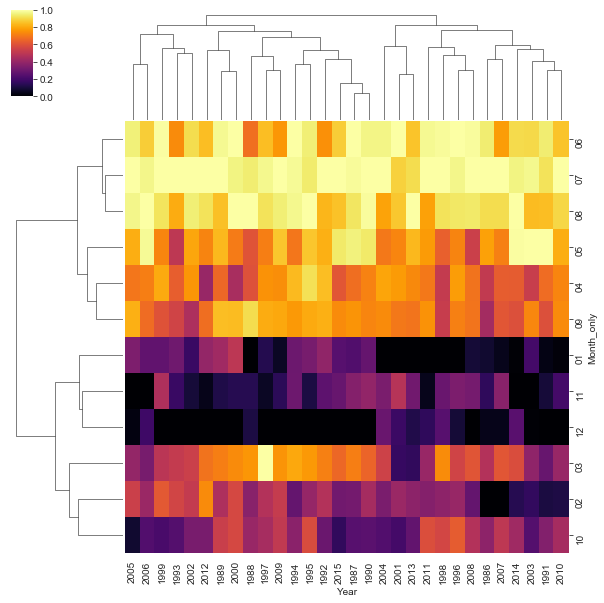

In [29]:
sns.clustermap(pt_heatmap, cmap = 'inferno', standard_scale = 1)

Sangat penasaran untuk mengamati bahwa nilai potensi energi angin terbaik juga bertepatan dengan bulan-bulan yang dianggap lebih menguntungkan untuk produksi energi surya, yaitu nilai-nilai terbaik berkisar dari April hingga September (~ Musim Semi ~ Musim Panas) dan nilai yang lebih rendah dari Oktober hingga Februari ( ~ Musim Gugur ~ Musim Dingin). Ada urutan tahun yang signifikan di mana March juga sangat produktif untuk sektor energi bertenaga angin.

## Mari kita melihatnya dari perspektif deret waktu

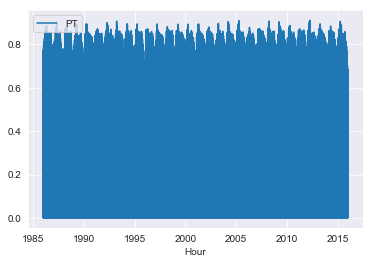

In [30]:
pt_ts = coun.filter(['Month','Year','PT'], axis = 1)
pt_ts.plot()

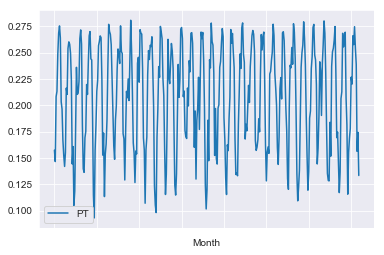

In [31]:
pt_ts_m = pt_ts.groupby('Month').mean()
pt_ts_m.plot()

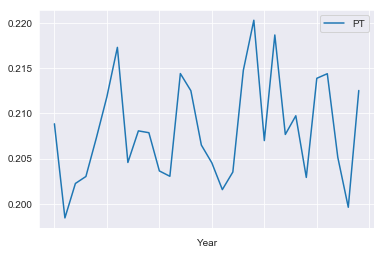

In [32]:
pt_ts_y = pt_ts.groupby('Year').mean()
pt_ts_y.plot()

## Menguji beberapa prediksi

Mari kita lihat apakah kita dapat mengembangkan model ANN untuk memprediksi nilai potensial energi angin jam berikutnya, dengan mempertimbangkan jendela putar 24 jam.

Ini hanya akan dianggap sebagai bulan terakhir tahun lalu untuk visualisasi yang lebih baik (negara - PT).

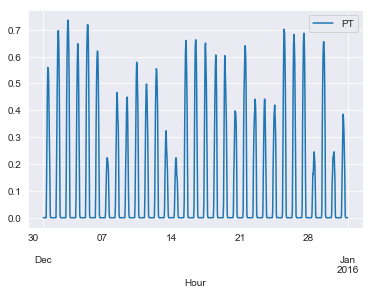

In [33]:
pt_nn = coun.filter(['Hour', 'PT'], axis = 1)

pt_nn = pt_nn.reset_index()
pt_nn['Hour'] = pd.to_datetime(pt_nn['Hour'])

start = pd.Timestamp('2015-12-01')
split = pd.Timestamp('2015-12-22')
pt_nn = pt_nn[pt_nn['Hour']>=start]

pt_nn = pt_nn.set_index('Hour')

pt_nn.plot()

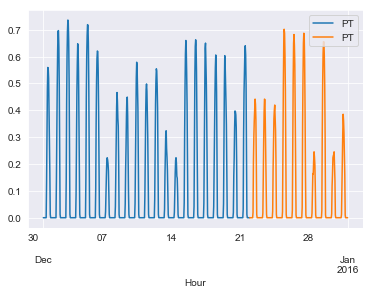

In [34]:
train = pt_nn.loc[:split, ['PT']]
test = pt_nn.loc[split:, ['PT']]
tr_pl = train
te_pl = test
ax = tr_pl.plot()
te_pl.plot(ax=ax)

Jadi set kereta saya berwarna biru, hingga 22 Desember, dan set tes saya sejak saat itu dan seterusnya (hijau).

In [35]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

X_train = train_sc[:-1]
y_train = X_train[1:]
X_train = X_train[:-1]            # in order for arrays to have same length

X_test = test_sc[:-1]
y_test = X_test[1:]
X_test = X_test[:-1]

### Menggulirkan Windows

In [36]:
train_df = pd.DataFrame(train_sc, columns = ['PT'], index = train.index )
test_df = pd.DataFrame(test_sc, columns = ['PT'], index = test.index )

In [37]:
for s in range(1, 25):
    train_df['shift {}'.format(s)] = train_df['PT'].shift(s, freq = 'H')
    test_df['shift {}'.format(s)] = test_df['PT'].shift(s, freq = 'H')

train_df.head(3)

,PT,shift 1,shift 2,shift 3,shift 4,shift 5,shift 6,shift 7,shift 8,shift 9,...,shift 15,shift 16,shift 17,shift 18,shift 19,shift 20,shift 21,shift 22,shift 23,shift 24
Hour,,,,,,,,,,,,,,,,,,,,,
2015-12-01 00:00:00,-0.645215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01 01:00:00,-0.645215,-0.645215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01 02:00:00,-0.645215,-0.645215,-0.645215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Di sini kita dapat melihat bagian dari pergeseran yang disebabkan oleh loop. Selanjutnya kita memotong frame data.

In [38]:
X_train = train_df.dropna().drop('PT', axis = 1)
y_train = train_df.dropna()[['PT']]

X_test = test_df.dropna().drop('PT', axis = 1)
y_test = test_df.dropna()[['PT']]
X_train.head(3)

,shift 1,shift 2,shift 3,shift 4,shift 5,shift 6,shift 7,shift 8,shift 9,shift 10,...,shift 15,shift 16,shift 17,shift 18,shift 19,shift 20,shift 21,shift 22,shift 23,shift 24
Hour,,,,,,,,,,,,,,,,,,,,,
2015-12-02 00:00:00,-0.645215,-0.645215,-0.645215,-0.645215,-0.645215,-0.645215,-0.588012,0.121304,0.842061,1.242481,...,0.899263,-0.038864,-0.645215,-0.645215,-0.645215,-0.645215,-0.645215,-0.645215,-0.645215,-0.645215
2015-12-02 01:00:00,-0.645215,-0.645215,-0.645215,-0.645215,-0.645215,-0.645215,-0.645215,-0.588012,0.121304,0.842061,...,1.585698,0.899263,-0.038864,-0.645215,-0.645215,-0.645215,-0.645215,-0.645215,-0.645215,-0.645215
2015-12-02 02:00:00,-0.645215,-0.645215,-0.645215,-0.645215,-0.645215,-0.645215,-0.645215,-0.645215,-0.588012,0.121304,...,1.963237,1.585698,0.899263,-0.038864,-0.645215,-0.645215,-0.645215,-0.645215,-0.645215,-0.645215


In [39]:
X_train.shape

(481, 24)

In [40]:
# to np.array
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

### Model Prediktif

In [41]:
# Needs to be re-dimensioned for LSTM layer
X_train_w = X_train.reshape(X_train.shape[0], 1, 24)
X_test_w = X_test.reshape(X_test.shape[0], 1, 24)
X_train_w.shape

(481, 1, 24)

In [46]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import keras.backend as K

ModuleNotFoundError: No module named 'keras'

In [ ]:
K.clear_session()

eps = 500
bs = 1

in_sh = (1, 24) 
hidden_1= 12
hidden_2= 12
outputs = 1

model = Sequential()
model.add(LSTM(hidden_1, input_shape = in_sh,))
model.add(Dense(hidden_2, activation ='relu'))
model.add(Dense(outputs))
model.compile(optimizer='adam', loss='mean_squared_error',)
model.summary()

In [ ]:
early_stop = EarlyStopping(monitor = 'loss', patience = 1, verbose = 1)

In [ ]:
model.fit(X_train_w, y_train, epochs = eps, batch_size = bs, verbose = 1 , callbacks = [early_stop])

In [ ]:
y_pred = model.predict(X_test_w)

In [ ]:
plt.plot(y_test)
plt.plot(y_pred)

pada percobaan yang terakhir saya mengalami kegagalan,mohon maaf